In [1]:
import pyspark
from pyspark.sql import SparkSession
from graphframes import GraphFrame

import networkx as nx
import re
from matplotlib import pyplot as plt
from igraph import Graph, plot
import pandas as pd
from pandas.core.common import flatten

In [2]:
LENGTHS_OF_K_MERS = [4]
LENGTH_OF_Q_MERS = 30   # q (short: 20, long: 30, 3species: 10)
NUM_SHARED_READS = 45   # m (short: 5, long: 45, 3species: 2)
N_WORKERS = 30
DATA_PATH = "../data/"
FILENAME_VERTICES = DATA_PATH + 'output_1_1_2.txt'
FILENAME_EDGES = DATA_PATH + 'output_2_1_2.txt'
IS_TFIDF = False
SMARTIRS = None

# BiMeta

Example of how to use `pyspark` and `graphframe` is in `test/spark/hello_graph.ipynb` 

## Read input file

### Read vertices

In [12]:
# Test clean line method
with open(FILENAME_VERTICES) as f:
    content = f.readlines()
    
a = content[0]

# Notice: There are differences between raw input and print()

# Long method
# a.replace('null\t', '').replace('\n', '').replace('[', '').replace(']', '').replace(' "','').replace('"','').split(',')

# Better method with regex
re.sub('[null\t\n\[\]\""]', '', a).replace(' ', '').split(',')

['0',
 'AAACCCTCTTCCACGAACCCTCTTGAAAATCCCCCACATCCACAAAATAAATCAAATAAATTTCAACATTATCACCAAAAGGGTAAAAGGTTATTTAAAAAATAAAATAAATTTAAAAATTTAAATTAAATACCAAAAAAGCCAAATAACTTATTGTGATTCTTGAGCTTTCTTTAACTCTGCCTTCATATCTTGATAGACTTTAGTCCATTTTAATTTTCTTGGATTTCTTCCCATTCTGTAGCTTTTCTCACATTTGGATGAGCAGAAATATAATACAGTCCCATCTTTTTCTACGACCATTTTTCCTTTTCCTGGCTCAATTTCATAACCACAAAAGCTGCATGTTCTCCATTCTGGCATAGCTATCCCCCTTTAATAGTGTTTCAGTGATTTTAAAATAATTTAAGATTAAATTATTTATCTTCTTCTGTCTAATGGTCTTGCTTCTCTCTCTGTTTCTCTTAACATAATAATGTCTCCAACTTTAACTGGACCTTTAACGTTTCTAACTAAAACTCTTCCAGTATCTTTTCCACCTAAGATTTTACATCTAACTTGTATAATTCCTCCAGTAACCCCTGTTCTACCAATGACTTCAATAACTTCAGCAGCTACTGCTTCCTTATAAACAAATTCATCTTCCGATCCTCATCACCTAATATTAATGAAGGTTTAAAATTTATAAAAAAGTTAGTAGTAGTGTTTCATAATTTATATAATAATAACTATATACTATTGATTGATGGTTAAATAGCGTTCTAATAATTTACTGCTTCAAAACATTTACCTTTTCAATTAATACCTTTAACTCTTCAGCATCTCCTTCGTTG',
 '0']

In [13]:
V = []

with open(FILENAME_VERTICES) as f:
    content_vertices = f.readlines()

for line in content_vertices:
    clean_line = re.sub('[null\t\n\[\]\""]', '', line).replace(' ', '').split(',')
    V.append(clean_line)
    
print(V[:2])

[['0', 'AAACCCTCTTCCACGAACCCTCTTGAAAATCCCCCACATCCACAAAATAAATCAAATAAATTTCAACATTATCACCAAAAGGGTAAAAGGTTATTTAAAAAATAAAATAAATTTAAAAATTTAAATTAAATACCAAAAAAGCCAAATAACTTATTGTGATTCTTGAGCTTTCTTTAACTCTGCCTTCATATCTTGATAGACTTTAGTCCATTTTAATTTTCTTGGATTTCTTCCCATTCTGTAGCTTTTCTCACATTTGGATGAGCAGAAATATAATACAGTCCCATCTTTTTCTACGACCATTTTTCCTTTTCCTGGCTCAATTTCATAACCACAAAAGCTGCATGTTCTCCATTCTGGCATAGCTATCCCCCTTTAATAGTGTTTCAGTGATTTTAAAATAATTTAAGATTAAATTATTTATCTTCTTCTGTCTAATGGTCTTGCTTCTCTCTCTGTTTCTCTTAACATAATAATGTCTCCAACTTTAACTGGACCTTTAACGTTTCTAACTAAAACTCTTCCAGTATCTTTTCCACCTAAGATTTTACATCTAACTTGTATAATTCCTCCAGTAACCCCTGTTCTACCAATGACTTCAATAACTTCAGCAGCTACTGCTTCCTTATAAACAAATTCATCTTCCGATCCTCATCACCTAATATTAATGAAGGTTTAAAATTTATAAAAAAGTTAGTAGTAGTGTTTCATAATTTATATAATAATAACTATATACTATTGATTGATGGTTAAATAGCGTTCTAATAATTTACTGCTTCAAAACATTTACCTTTTCAATTAATACCTTTAACTCTTCAGCATCTCCTTCGTTG', '0'], ['1', 'TAGCATGTAAATCCCTTATTTCTTAATTTCTCCCAGAATTATTTCTATTGCTTTATCAACTGCCTTGGCAACCTCTTCAGACAACCCTGGTTTTATGTCTGGCATTGTAAATTTTTACCTTGACAACCAATAACCACGACTTC

In [14]:
df_vertices = pd.DataFrame(V, columns=["id", "read", "label"])
df_vertices.head()

,id,read,label
0,0,AAACCCTCTTCCACGAACCCTCTTGAAAATCCCCCACATCCACAAA...,0
1,1,TAGCATGTAAATCCCTTATTTCTTAATTTCTCCCAGAATTATTTCT...,0
2,2,GACTATAAGGCTGTCTTTAACTATATCTTATGTAGGGAAGCAGACA...,0
3,3,TTTCTATATAAACTTCTTCAATTCCTGCTGCCGATAATGAAGGGAC...,0
4,4,GGGAGGACCGCCAATAATAACATCTACTTTTTTATTTTTGATGAAC...,0


### Read edges

In [71]:
# Method 1: Format input file as dictionary format like original notebook code

E = {}

with open(FILENAME_EDGES) as f:
    content_edges = f.readlines()

for line in content_edges:
    # Get number character only -> remove leading and trailing whitespaces -> splits a string into a list (separator: whitespace)
    clean_line = re.sub("[^0-9]", " ", line).strip().split()
    e_curr = (clean_line[0],  clean_line[1])
    E[e_curr] = clean_line[2]
    
print(E)

{('0', '4'): '394'}


In [72]:
# Contain pairs of reads that is connected (edge weight >= NUM_SHARED_READS is connected)
E_Filtered = {kv[0]: kv[1] for kv in E.items() if int(kv[1]) >= NUM_SHARED_READS}
E_Filtered

{('0', '4'): '394'}

In [73]:
# Method 2: Format input file as list format for easier to create dataframe

E = []

with open(FILENAME_EDGES) as f:
    content_edges = f.readlines()

for line in content_edges:
    # Get number character only -> remove leading and trailing whitespaces -> splits a string into a list (separator: whitespace)
    clean_line = re.sub("[^0-9]", " ", line).strip().split()
    E.append([clean_line[0],  clean_line[1], clean_line[2]])
    
print(E)

[['0', '4', '394']]


In [74]:
E_Filtered = [kv for kv in E if int(kv[2]) >= NUM_SHARED_READS]
E_Filtered

[['0', '4', '394']]

In [65]:
# Original notebook code using networkx

def build_graph(E_Filtered, labels):
    # Building graph
    G = nx.Graph()
    # Adding nodes
    color_map = {
        0: "red",
        1: "green",
        2: "blue",
        3: "yellow",
        4: "darkcyan",
        5: "violet",
        6: "black",
        7: "grey",
        8: "sienna",
        9: "wheat",
        10: "olive",
        11: "lightgreen",
        12: "cyan",
        13: "slategray",
        14: "navy",
        15: "hotpink",
    }
    for i in range(0, len(labels)):
        G.add_node(i, label=labels[i], color=color_map[labels[i]])

    # Adding edges
    for kv in E_Filtered.items():
        G.add_edge(kv[0][0], kv[0][1], weight=kv[1])

    return G

In [55]:
df_edges = pd.DataFrame(E_Filtered, columns=['src', 'dst', 'weight'])
df_edges.head()

,src,dst,weight
0,0,4,394


## Create graph

In [56]:
spark = SparkSession.builder.appName("build_graph").getOrCreate()

In [57]:
vertices = spark.createDataFrame(df_vertices)

In [58]:
edges = spark.createDataFrame(df_edges)

In [60]:
g = GraphFrame(vertices, edges)

In [61]:
g.vertices.show()

+---+--------------------+-----+
| id|                read|label|
+---+--------------------+-----+
|  0|AAACCCTCTTCCACGAA...|    0|
|  1|TAGCATGTAAATCCCTT...|    0|
|  2|GACTATAAGGCTGTCTT...|    0|
|  3|TTTCTATATAAACTTCT...|    0|
|  4|GGGAGGACCGCCAATAA...|    0|
|  5|GAATCAGAATCATCTTC...|    1|
|  6|AAAATCAGAAGTTTTTG...|    1|
+---+--------------------+-----+



In [62]:
g.edges.show()

+---+---+------+
|src|dst|weight|
+---+---+------+
|  0|  4|   394|
+---+---+------+



## Visualize graph

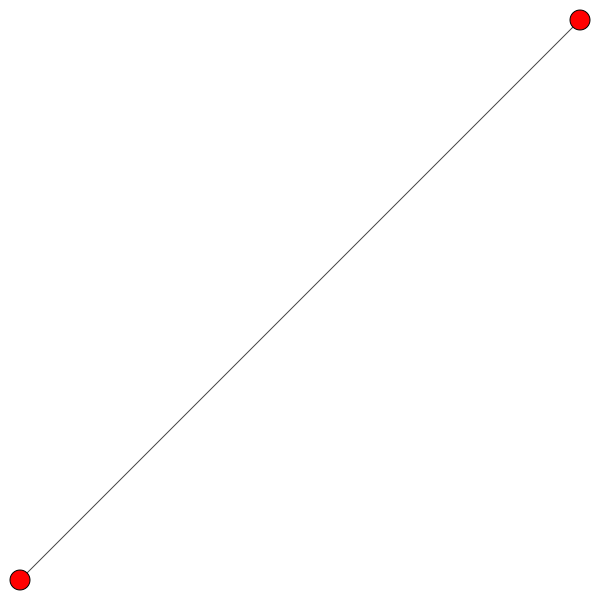

In [69]:
ig = Graph.TupleList(g.edges.collect(), directed=False)
plot(ig)